## 可視化

## 共起ネットワークの表示

このセルの実行には，「ginzaの使い方」ノートブックにある，「パッケージのインストール」と「解析対象のデータをダウンロード」を予め実行しておく必要がある．

まずは，「ginzaの使い方」ノートブックの「単語の共起」と同じ処理を行う．

In [1]:
import spacy 
input_fn = 'text/kageotoko.corpus.txt'

include_pos = ('NOUN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう', 'いる', 'くる')

nlp = spacy.load("ja_ginza")

In [2]:
def extract_words(sent, pos_tags, stopwords):
    words = [token.lemma_ for token in sent
             if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def count_cooccurrence(sents, token_length='{2,}'):
    token_pattern=f'\\b\\w{token_length}\\b'
    count_model = CountVectorizer(token_pattern=token_pattern)

    X = count_model.fit_transform(sents)
    words = count_model.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)

    X[X > 0] = 1 # limit to 1 occurrence in a document.
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    return words, word_counts, Xc, X

In [4]:
def chunk(lst, n):
    """
    リストをn個ずつのサブリストに分割する。
    """
    return [lst[i:i+n] for i in range(0, len(lst), n)]


with open(input_fn, 'r') as f:
    lines = [l.replace("\n","") for l in f.readlines()]

lst_texts = chunk(lines,100)
sents = []
list_sents = []
for text in lst_texts:
    doc = nlp(" ".join(text))
    sents.extend([' '.join(extract_words(sent, include_pos, stopwords))
                  for sent in doc.sents])
    list_sents.extend(doc.sents)

words, word_counts, Xc, X = count_cooccurrence(sents)

共起ネットワーク図を見やすくするために，単語の出現数に応じた頂点の大きさ，共起の多さに応じた辺の太さを表示し分ける．そのための，重みを求める関数を作成する．

In [5]:
def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [(word, {'weight': count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc, weight_cutoff):
    Xc_max = Xc.max()
    cutoff = weight_cutoff * Xc_max
    weights = [(words[i], words[j], Xc[i,j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

重み付き頂点と重み付き辺からグラフを作成する関数を作成する．

In [6]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import japanize_matplotlib

def create_network(words, word_counts, Xc, weight_cutoff):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    # pyvis_G.from_nx(G) # pyvisライブラリ現状では，属性が反映されない．
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

以上の関数を呼び出して，グラフを描画する．２つの共起ネットワークが表示され，最初の図は静的なもの，次の図はブラウザでの閲覧によってマウス操作でネットワークのノードの配置を動かすことができる．ノードが密集している部分は，着目したノードをマウスで掴んで引っ張って，そのノードに結合している他のノードを視覚的に捉えることができる．

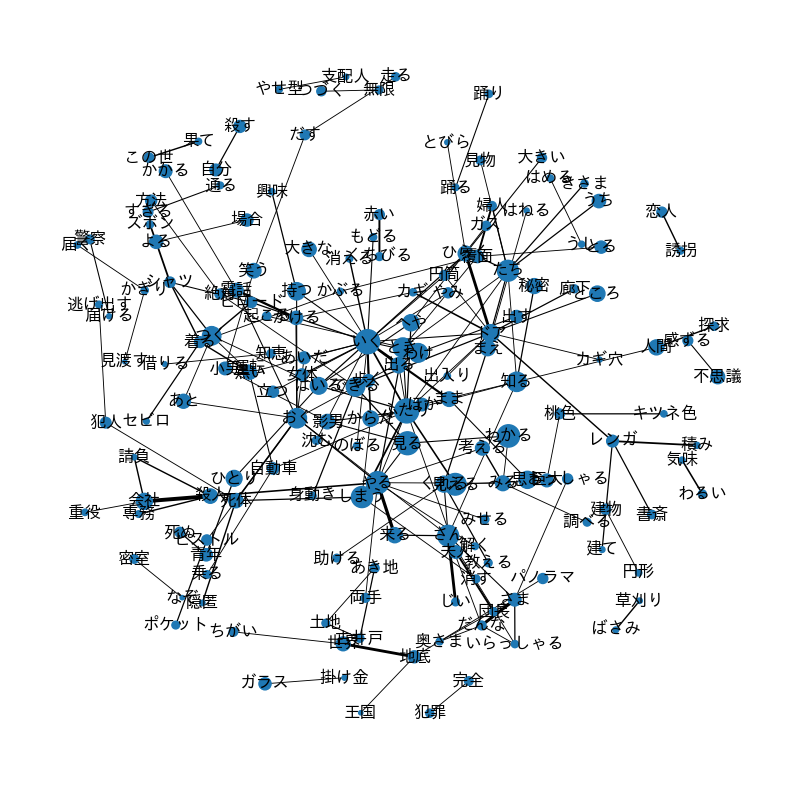

mygraph.html


In [7]:
G = create_network(words, word_counts, Xc, 0.03)
pyplot_network(G)
pyvis_G = nx2pyvis_G(G)
pyvis_G.show("mygraph.html")

共起ネットワークを見ているうちに，「人間」と「探求」の共起に興味が及んだので，原文を見てみる．

In [8]:
def find_sentence_by_cooccurrence(X, idxs):
    occur_flags = (X[:,idxs[0]] > 0)
    for idx in idxs[1:]:
        occur_flags = occur_flags.multiply(X[:,idx] > 0)
    return occur_flags.nonzero()[0]

sents_orig = list(doc.sents)
words_lookup = {word: index for index, word in enumerate(words)}
idxs = [words_lookup[word] for word in ['人間', '探求']]

for i in find_sentence_by_cooccurrence(X, idxs):
    print("{:>5d}: {}".format(i, list_sents[i]))

  140: かれは人間というものの探求を生きがいとするようになっていた。
  143: かれはその裏側のほうの人間を探求しようとしたのである。
  145: しかし、普通犯罪学者がやるような一般的研究ではなくて、これと目ざした個々の人間の、世間にも、その人自身の家族にさえも知られていない秘密の生活を探求することが、かれの生きがいであった。
  194: 　かれの人間裏返しの探求には、いま一つの副産物があった。
  199: かれの「裏返しの人間探求」の副産物にすぎなかった。
  201: 隠身術による人間探求の結果を、小説の形でそれとなく世間に見せびらかすのが楽しかったのである。
  213: それらの恋人を、かれは人間探求事業の助手として巧みに駆使していた。
 1255: 裏返しの人間探求というかれの事業は、つまり物の逆を探ることであった。
